## Pipeline de um processo de Deep Learning implementado em PyTorch:

    1. Preparar os Dados
    2. Definir o Modelo
    3. Treinar o Modelo
    4. Avaliar o Modelo
    5. Usar o Modelo


## **MLP para classificação multiclasse**
**Dataset Iris (flores)**
- Dataset de imagens para previsão da espécie da flor dadas as medidas das flores
- 3 classes com 50 instâncias cada
- Classes: Iris Setosa, Iris Versicolour e Iris Virginica
- 5 atributos: 4 para dimensões numéricas e o 5º a classe da flor

In [1]:
import torch
print(torch.__version__)

1.13.1+cpu


## Imports

In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, classification_report
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.utils.data import random_split
from torch import Tensor
from torch.nn import Linear
from torch.nn import ReLU
from torch.nn import Softmax
from torch.nn import Module
from torch.optim import SGD, Adam
from torch.nn import CrossEntropyLoss
from torch.nn.init import kaiming_uniform_
from torch.nn.init import xavier_uniform_

np.random.seed(0) 
torch.manual_seed(0)
import random
random.seed(0)

In [3]:
PATH = 'iris.csv'

device = torch.device("cpu")

EPOCHS = 100
BATCH_SIZE = 32
LEARNING_RATE = 0.01

## 1. Preparar os Dados

In [4]:
class CSVDataset(Dataset):
    def __init__(self, path):
        df = pd.read_csv(path, header=None)
        self.X = df.values[:, :-1]
        self.y = df.values[:, -1]
        self.X = self.X.astype('float32')
        self.y = LabelEncoder().fit_transform(self.y)
        
    def __len__(self):
        return len(self.X)
 
    def __getitem__(self, idx):
        return [self.X[idx], self.y[idx]]
 
    def get_splits(self, n_test=0.33):
        test_size = round(n_test * len(self.X))
        train_size = len(self.X) - test_size
        return random_split(self, [train_size, test_size], generator=torch.Generator().manual_seed(42))
    
def prepare_data(path):
    dataset = CSVDataset(path)
    train, test = dataset.get_splits()
    train_dl = DataLoader(train, batch_size=32, shuffle=True)
    test_dl = DataLoader(test, batch_size=1024, shuffle=False)
    train_dl_all = DataLoader(train, batch_size=len(train), shuffle=False)
    test_dl_all = DataLoader(test, batch_size=len(test), shuffle=False)
    return train_dl, test_dl, train_dl_all, test_dl_all

train_dl, test_dl,  train_dl_all, test_dl_all = prepare_data(PATH)

## 1.1 Visualizar os Dados

In [5]:
from IPython.display import display

def visualize_data(path):
    # criar uma instância do dataset
    df = pd.read_csv(path, header=None)
    display(df)

def visualize_dataset(train_dl, test_dl):
    print(f"Quantidade de casos de Treino:{len(train_dl.dataset)}") 
    print(f"Quantidade de casos de Teste:{len(test_dl.dataset)}")
    x, y = next(iter(train_dl)) #fazer uma iteração nos loaders para ir buscar um batch de casos
    print(f"Shape tensor batch casos treino, input: {x.shape}, output: {y.shape}")
    x, y = next(iter(test_dl))  
    print(f"Shape tensor batch casos teste, input: {x.shape}, output: {y.shape}")

visualize_data(PATH)
visualize_dataset(train_dl, test_dl)

,0,1,2,3,4
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa
...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,Iris-virginica
146,6.3,2.5,5.0,1.9,Iris-virginica
147,6.5,3.0,5.2,2.0,Iris-virginica
148,6.2,3.4,5.4,2.3,Iris-virginica


Quantidade de casos de Treino:100
Quantidade de casos de Teste:50
Shape tensor batch casos treino, input: torch.Size([32, 4]), output: torch.Size([32])
Shape tensor batch casos teste, input: torch.Size([50, 4]), output: torch.Size([50])


## 1.2 Verificar o balanceamento do dataset

casos_treino: 100
g_Train:  33
b_Train:  38
g_Train/b_Train:  0.868421052631579
casos_test: 50
g_Test:  17
b_Test:  12
g_Test/b_Test:  1.4166666666666667


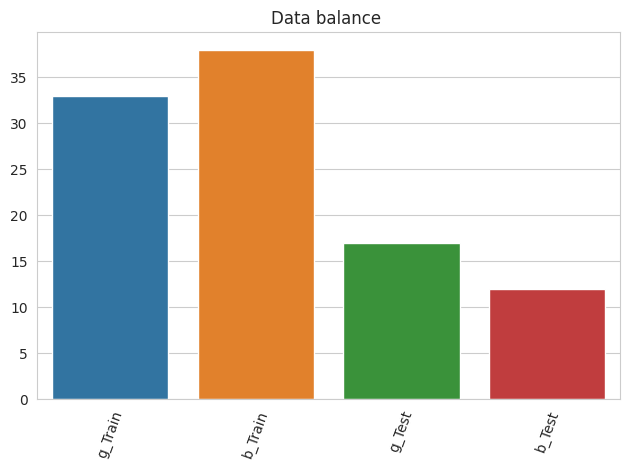

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt

def visualize_holdout_balance(train_dl, test_dl):
    _, y_train = next(iter(train_dl))                            
    _, y_test = next(iter(test_dl))

    sns.set_style('whitegrid')
    casos_treino=len(y_train) # calcular o nº de casos de treino
    casos_test=len(y_test) # calcular o nº de casos de teste
    b_Train=np.count_nonzero(y_train == 0) # calcular o nº de 0 nos casos de treino
    g_Train = np.count_nonzero(y_train == 1) # calcular o nº de 1 nos casos de treino
    b_Test=np.count_nonzero(y_test == 0) # calcular o nº de 0 nos casos de teste
    g_Test = np.count_nonzero(y_test == 1) # calcular o nº de 1 nos casos de teste
    print("casos_treino:",casos_treino)
    print("g_Train: ", g_Train)
    print("b_Train: ", b_Train)
    print("g_Train/b_Train: ", g_Train/b_Train) # rácio de g em b
    print("casos_test:",casos_test)
    print("g_Test: ", g_Test)
    print("b_Test: ", b_Test)
    print("g_Test/b_Test: ", g_Test/b_Test) # rácio de g em b

    grafico=sns.barplot(x=['g_Train','b_Train', 'g_Test', 'b_Test'], 
                        y=[g_Train,b_Train, g_Test, b_Test])
    grafico.set_title('Data balance ')
    plt.xticks(rotation=70)
    plt.tight_layout()
    plt.show() 
    
visualize_holdout_balance(train_dl_all, test_dl_all)

## 2. Definir o Modelo

In [7]:
from torchinfo import summary

class MLP(Module):
    def __init__(self, n_inputs):
        super(MLP, self).__init__()
        self.hidden1 = Linear(n_inputs, 10)
        kaiming_uniform_(self.hidden1.weight, nonlinearity='relu')
        self.act1 = ReLU()
        self.hidden2 = Linear(10, 8)
        kaiming_uniform_(self.hidden2.weight, nonlinearity='relu')
        self.act2 = ReLU()
        self.hidden3 = Linear(8,3)
        xavier_uniform_(self.hidden3.weight)
        self.act3 = Softmax(dim=1)
 
    def forward(self, X):
        X = self.hidden1(X)
        X = self.act1(X)
        X = self.hidden2(X)
        X = self.act2(X)
        X = self.hidden3(X)
        X = self.act3(X)
        return X

model = MLP(4)
print(summary(model, input_size=(BATCH_SIZE, 4), verbose=0))
model.to(device)

Layer (type:depth-idx)                   Output Shape              Param #
MLP                                      [32, 3]                   --
├─Linear: 1-1                            [32, 10]                  50
├─ReLU: 1-2                              [32, 10]                  --
├─Linear: 1-3                            [32, 8]                   88
├─ReLU: 1-4                              [32, 8]                   --
├─Linear: 1-5                            [32, 3]                   27
├─Softmax: 1-6                           [32, 3]                   --
Total params: 165
Trainable params: 165
Non-trainable params: 0
Total mult-adds (M): 0.01
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 0.00
Estimated Total Size (MB): 0.01


MLP(
  (hidden1): Linear(in_features=4, out_features=10, bias=True)
  (act1): ReLU()
  (hidden2): Linear(in_features=10, out_features=8, bias=True)
  (act2): ReLU()
  (hidden3): Linear(in_features=8, out_features=3, bias=True)
  (act3): Softmax(dim=1)
)

## 3. Treinar o Modelo

In [8]:
def train_model(train_dl, model):
    criterion = CrossEntropyLoss()
    optimizer = SGD(model.parameters(), lr=LEARNING_RATE, momentum=0.5) # stochastic gradient descent
    #optimizer = Adam(model.parameters(), lr=LEARNING_RATE)
    for epoch in range(EPOCHS):
        for i, (inputs, targets) in enumerate(train_dl):
            optimizer.zero_grad()
            yprev = model(inputs)
            loss = criterion(yprev, targets)
            loss.backward()
            optimizer.step()
            
train_model(train_dl, model)

## 4. Avaliar o Modelo

In [9]:
def evaluate_model(test_dl, model):
    predictions = list()
    actual_values = list()
    for i, (inputs, labels) in enumerate(test_dl):
        yprev = model(inputs)
        yprev = yprev.detach().numpy()
        actual = labels.numpy()
        
        yprev = np.argmax(yprev, axis=1)
        actual = actual.reshape((len(actual), 1))
        yprev = yprev.reshape((len(yprev), 1))
        
        predictions.append(yprev)
        actual_values.append(actual)
        break
    predictions, actual_values = np.vstack(predictions), np.vstack(actual_values)
    return predictions, actual_values
 
def display_confusion_matrix(cm):
    plt.figure(figsize = (16,8))
    
    sns.heatmap(cm, annot=True, xticklabels=['Iris-setosa', 'Iris-versicolor','Iris-virginica'], yticklabels=['Iris-setosa', 'Iris-versicolor','Iris-virginica'], annot_kws={"size": 12}, fmt='g', linewidth=.5)
    
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show() 
    
predictions, actual_values = evaluate_model(test_dl, model)

acertou = 0
falhou = 0
for r,p in zip(actual_values, predictions):
    print(f'real:{r} previsão:{p}') 
    if r==p: acertou+=1  
    else: falhou+=1

acc = accuracy_score(actual_values, predictions)
print(f'Accuracy: {acc:0.3f}\n')
print(f'acertou:{acertou} falhou:{falhou}')

real:[1] previsão:[1]
real:[1] previsão:[1]
real:[1] previsão:[1]
real:[0] previsão:[1]
real:[0] previsão:[1]
real:[0] previsão:[1]
real:[2] previsão:[2]
real:[1] previsão:[1]
real:[0] previsão:[1]
real:[2] previsão:[2]
real:[2] previsão:[2]
real:[1] previsão:[1]
real:[0] previsão:[1]
real:[1] previsão:[1]
real:[2] previsão:[2]
real:[0] previsão:[1]
real:[2] previsão:[2]
real:[1] previsão:[1]
real:[2] previsão:[2]
real:[2] previsão:[2]
real:[1] previsão:[2]
real:[2] previsão:[2]
real:[2] previsão:[2]
real:[1] previsão:[1]
real:[1] previsão:[1]
real:[1] previsão:[1]
real:[2] previsão:[2]
real:[1] previsão:[2]
real:[0] previsão:[1]
real:[0] previsão:[1]
real:[2] previsão:[2]
real:[0] previsão:[1]
real:[2] previsão:[2]
real:[0] previsão:[1]
real:[2] previsão:[2]
real:[1] previsão:[1]
real:[1] previsão:[1]
real:[1] previsão:[2]
real:[2] previsão:[2]
real:[2] previsão:[2]
real:[2] previsão:[2]
real:[2] previsão:[2]
real:[1] previsão:[1]
real:[2] previsão:[2]
real:[1] previsão:[1]
real:[0] p

## 5. Usar o Modelo

In [10]:
def predict(row, model):
    row = Tensor([row])
    yprev = model(row)
    yprev = yprev.detach().numpy()
    return yprev

# só pode ter 4 entradas  5.1,3.5,1.4,0.2
row = [1,0,0.99539,-0.05889]
yprev = predict(row, model)
print('Predicted: %s (class=%d)' % (yprev, np.argmax(yprev)))

Predicted: [[0.15977275 0.38330355 0.45692372]] (class=2)
